#Data Load

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from collections import defaultdict

In [ ]:
!pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tslearn.piecewise import SymbolicAggregateApproximation
from tslearn.preprocessing import TimeSeriesScalerMeanVariance


In [ ]:
y_train = pd.read_fwf("y_train.txt", header = None)[0]
y_test = pd.read_fwf("y_test.txt", header = None)[0]

subject_train = pd.read_csv("subject_train.txt", header = None)[0]
subject_test = pd.read_csv("subject_test.txt", header = None)[0]

body_x = pd.read_fwf("body_acc_x_train.txt", header = None)
body_y = pd.read_fwf("body_acc_y_train.txt", header = None)
body_z = pd.read_fwf("body_acc_z_train.txt", header = None)

#acc_x = pd.read_fwf("total_acc_x_train.txt", header = None)
#acc_y = pd.read_fwf("total_acc_y_train.txt", header = None)
#acc_z = pd.read_fwf("total_acc_z_train.txt", header = None)

gyro_x = pd.read_fwf("body_gyro_x_train.txt", header = None)
gyro_y = pd.read_fwf("body_gyro_y_train.txt", header = None)
gyro_z = pd.read_fwf("body_gyro_z_train.txt", header = None)

body_x_test = pd.read_fwf("body_acc_x_test.txt", header = None)
body_y_test = pd.read_fwf("body_acc_y_test.txt", header = None)
body_z_test = pd.read_fwf("body_acc_z_test.txt", header = None)

#acc_x_test = pd.read_fwf("total_acc_x_test.txt", header = None)
#acc_y_test = pd.read_fwf("total_acc_y_test.txt", header = None)
#acc_z_test = pd.read_fwf("total_acc_z_test.txt", header = None)

gyro_x_test = pd.read_fwf("body_gyro_x_test.txt", header = None)
gyro_y_test = pd.read_fwf("body_gyro_y_test.txt", header = None)
gyro_z_test = pd.read_fwf("body_gyro_z_test.txt", header = None)

In [ ]:
with open("features.txt") as f:
    lines = f.read().splitlines()
    
features = {}
for line in lines:
    idx, name = line.split()
    features[int(idx)-1] = name

In [ ]:
with open('activity_labels.txt') as f:
    lines = f.read().splitlines()

activities = {}
for line in lines:
    label, activity = line.split()
    activities[int(label)] = activity

In [ ]:
y_train_mapped = y_train.map(activities)
y_test_mapped = y_test.map(activities)

In [ ]:
dict_dfs = {'body_x': body_x,
            'body_y': body_y,
            'body_z': body_z,
            #'acc_x' : acc_x,
            #'acc_y' : acc_y,
            #'acc_z' : acc_z,
            'gyro_x': gyro_x,
            'gyro_y': gyro_y,
            'gyro_z': gyro_z}

for name_df, df in dict_dfs.items():
    last_row = df.iloc[-1:,64:]
    last_row.columns = np.arange(64) # rename columns of the last raw
    first64 = df.iloc[:,:64]
    dict_dfs[name_df] = pd.concat([first64, last_row], ignore_index=True)
    # aggiungiamo anche le colonne ID soggetto e tipo di attività svolta
    dict_dfs[name_df]['subject'] = subject_train
    dict_dfs[name_df]['activity'] = y_train_mapped
    dict_dfs[name_df].iloc[-1, -2:] = dict_dfs[name_df].iloc[-2, -2:]
    dict_dfs[name_df]['subject'] = dict_dfs[name_df]['subject'].astype(int)

In [ ]:
dict_dfs_test = {'body_x_test': body_x_test,
                 'body_y_test': body_y_test,
                 'body_z_test': body_z_test,
                 #'acc_x_test': acc_x_test,
                 #'acc_y_test': acc_y_test,
                 #'acc_z_test': acc_z_test,
                 'gyro_x_test': gyro_x_test,
                 'gyro_y_test': gyro_y_test,
                 'gyro_z_test': gyro_z_test}

for name_df, df in dict_dfs_test.items():
    last_row = df.iloc[-1:,64:]
    last_row.columns = np.arange(64) # rename columns of the last raw
    first64 = df.iloc[:,:64]
    dict_dfs_test[name_df] = pd.concat([first64, last_row], ignore_index=True)
    # aggiungiamo anche le colonne ID soggetto e tipo di attività svolta
    dict_dfs_test[name_df]['subject'] = subject_test
    dict_dfs_test[name_df]['activity'] = y_train_mapped
    dict_dfs_test[name_df].iloc[-1, -2:] = dict_dfs_test[name_df].iloc[-2, -2:]
    dict_dfs_test[name_df]['subject'] = dict_dfs_test[name_df]['subject'].astype(int)
    
                
#df_ts_test = pd.DataFrame(dict_dfs_ts_test)


In [ ]:
file = [body_x, body_y, body_z,  gyro_x, gyro_y, gyro_z]
X_train = list()
for df in file:
    X_train.append(df.values[:, :, np.newaxis])
X_train = np.concatenate(X_train, axis=2)
X_train = np.array(X_train)


file = [body_x, body_y, body_z, gyro_x, gyro_y, gyro_z]
X_train = list()
for df in file:
    X_train.append(df.values[:, :, np.newaxis])
X_train = np.concatenate(X_train, axis=2)
X_train = np.array(X_train)

In [ ]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

#Transforamtion

In [ ]:
!pip install prefixspan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for prefixspan: filename=prefixspan-0.5.2-py3-none-any.whl size=11239 sha256=9415862d18c550f8b798daefbfd040ca430316112e2f54e0693246dccddfb890
  Stored in directory: /root/.cache/pip/wheels/99/6a/87/7170158a87b97a642d620ea1767f6519d2cf7db33cac1098ac
  Created wheel for extratools: filename=extratools-0.8.2.1-py3-none-any.whl size=28885 sha256=dd9dd58577f703714d4a2f65c5e2231fd7c10ca7347132532df9136a0b3edcbf
  Stored in directory: /root/.cache/pip/wheels/78/c4/9d/581ca1511b5a7731bf2406c840dd445a6a8b8e494d29aa1c68
Successfully built prefixspan extratools


In [ ]:
from prefixspan import PrefixSpan

In [ ]:
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
n_paa_segments = 20
n_sax_symbols = 10
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)


X_train=[] #dimensioni: (105,max(TS),6)
X_test=[]
X_prova=[]

for act in [activities[k] for k in range(1,7)]:
  X_train_feat=[] #qua dentro ci vanno una cosa (105,max(TS))
  X_test_feat=[]

  for name_df,df in dict_dfs.items(): 

    X_train_act=[] #qua ci va (21,max(TS)), devo concatenarli uno dopo l'altro
    X_test_act=[]
    temp_train=df
    temp_test=dict_dfs_test[name_df+'_test']

    temp1_train=temp_train.loc[temp_train['activity']==act]
    temp1_test=temp_test.loc[temp_test['activity']==act]

    for subject in subject_train.unique():
      temp2=temp1_train.loc[temp1_train['subject']==subject]
      temp2=temp2.iloc[:,:-2]
      temp2=clean_dataset(temp2)
      ts=temp2.values.ravel()
      ts = scaler.fit_transform(ts.reshape(1,-1))     
      ts = sax.fit_transform(ts)
      ts=ts.ravel()
      ts=[str(x)+'_'+name_df for x in ts]
      ts=np.array(ts)
      X_train_act.append(ts)

    for subject in subject_test.unique():
      temp2=temp1_test.loc[temp1_test['subject']==subject]
      temp2=temp2.iloc[:,:-2]
      temp2=clean_dataset(temp2)
      ts=temp2.values.ravel()
      ts = scaler.fit_transform(ts.reshape(1,-1))      
      ts = sax.fit_transform(ts)
      ts=ts.ravel()
      ts=[str(x)+'_'+name_df for x in ts]
      ts=np.array(ts)
      ts=np.array(ts.ravel())
      X_test_act.append(ts)
    X_train_feat.append(X_train_act)
    X_test_feat.append(X_test_act)
  X_train_feat=[j for sub in X_train_feat for j in sub]
  X_test_feat=[j for sub in X_test_feat for j in sub]
  X_prova_feat=np.append(X_train_feat,X_test_feat,axis=0)
  X_train.append(X_train_feat)
  X_test.append(X_test_feat)
  X_prova.append(X_prova_feat)

X_train=np.array(X_train)
X_test=np.array(X_test)
X_prova=np.array(X_prova)
#df_X_train = pd.DataFrame(X_train_act)
#cluster_train=df_X_train.values
#df_X_test = pd.DataFrame(X_test_act)
#cluster_test=df_X_test.values

In [ ]:
X_prova.shape

(6, 180, 20)

In [ ]:
X_walking=X_prova[0]
X_walking_up=X_prova[1]
X_walking_down=X_prova[2]
X_sitting=X_prova[3]
X_standing=X_prova[4]
X_laying=X_prova[5]

In [ ]:
X_walking.shape

(180, 20)

In [ ]:
df = pd.DataFrame(X_walking)

In [ ]:
df_stamp=df.head()

In [ ]:
df_stamp2=df.tail()

In [ ]:
print(df_stamp.to_latex())

\begin{tabular}{lllllllllllllllllllll}
\toprule
{} &        0  &        1  &        2  &        3  &        4  &        5  &        6  &        7  &        8  &        9  &        10 &        11 &        12 &        13 &        14 &        15 &        16 &        17 &        18 &        19 \\
\midrule
0 &  4\_body\_x &  5\_body\_x &  5\_body\_x &  5\_body\_x &  4\_body\_x &  5\_body\_x &  5\_body\_x &  4\_body\_x &  5\_body\_x &  4\_body\_x &  5\_body\_x &  5\_body\_x &  4\_body\_x &  5\_body\_x &  4\_body\_x &  4\_body\_x &  5\_body\_x &  4\_body\_x &  5\_body\_x &  4\_body\_x \\
1 &  4\_body\_x &  5\_body\_x &  5\_body\_x &  5\_body\_x &  5\_body\_x &  4\_body\_x &  5\_body\_x &  4\_body\_x &  5\_body\_x &  4\_body\_x &  5\_body\_x &  4\_body\_x &  5\_body\_x &  4\_body\_x &  4\_body\_x &  5\_body\_x &  4\_body\_x &  5\_body\_x &  5\_body\_x &  5\_body\_x \\
2 &  4\_body\_x &  5\_body\_x &  5\_body\_x &  4\_body\_x &  4\_body\_x &  4\_body\_x &  5\_body\_x &  5\_body\_x &  4\_body\_x

In [ ]:
print(df_stamp2.to_latex())

\begin{tabular}{lllllllllllllllllllll}
\toprule
{} &        0  &        1  &        2  &        3  &        4  &        5  &        6  &        7  &        8  &        9  &        10 &        11 &        12 &        13 &        14 &        15 &        16 &        17 &        18 &        19 \\
\midrule
175 &  2\_gyro\_z &  1\_gyro\_z &  5\_gyro\_z &  4\_gyro\_z &  4\_gyro\_z &  4\_gyro\_z &  9\_gyro\_z &  8\_gyro\_z &  4\_gyro\_z &  4\_gyro\_z &  4\_gyro\_z &  4\_gyro\_z &  2\_gyro\_z &  2\_gyro\_z &  5\_gyro\_z &  4\_gyro\_z &  4\_gyro\_z &  5\_gyro\_z &  9\_gyro\_z &  4\_gyro\_z \\
176 &  7\_gyro\_z &  5\_gyro\_z &  4\_gyro\_z &  4\_gyro\_z &  2\_gyro\_z &  4\_gyro\_z &  4\_gyro\_z &  4\_gyro\_z &  8\_gyro\_z &  6\_gyro\_z &  5\_gyro\_z &  4\_gyro\_z &  4\_gyro\_z &  4\_gyro\_z &  4\_gyro\_z &  3\_gyro\_z &  4\_gyro\_z &  4\_gyro\_z &  3\_gyro\_z &  4\_gyro\_z \\
177 &  4\_gyro\_z &  4\_gyro\_z &  4\_gyro\_z &  4\_gyro\_z &  5\_gyro\_z &  4\_gyro\_z &  5\_gyro\_z &  5\_gyro\_z &  4\_g

#WALKING

In [ ]:
ps = PrefixSpan(X_walking)

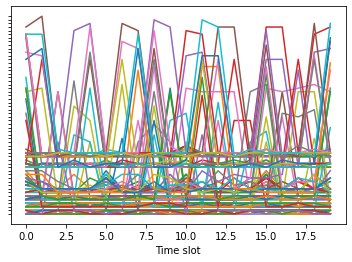

In [ ]:
for i in range(0,180):
  plt.plot(X_walking[i])
plt.xlabel('Time slot')
#plt.ylabel('TS')
frame1 = plt.gca()
#frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
#plt.savefig('X_walking_TS.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
ps.topk(10,filter=lambda patt, matches: len(patt) > 10)

[(24,
  ['4_body_x',
   '5_body_x',
   '5_body_x',
   '4_body_x',
   '5_body_x',
   '4_body_x',
   '5_body_x',
   '5_body_x',
   '5_body_x',
   '5_body_x',
   '4_body_x']),
 (23,
  ['4_body_x',
   '5_body_x',
   '4_body_x',
   '5_body_x',
   '4_body_x',
   '4_body_x',
   '5_body_x',
   '4_body_x',
   '4_body_x',
   '4_body_x',
   '4_body_x']),
 (23,
  ['4_body_x',
   '5_body_x',
   '4_body_x',
   '5_body_x',
   '4_body_x',
   '5_body_x',
   '4_body_x',
   '5_body_x',
   '4_body_x',
   '4_body_x',
   '4_body_x']),
 (23,
  ['4_body_x',
   '5_body_x',
   '4_body_x',
   '5_body_x',
   '4_body_x',
   '5_body_x',
   '4_body_x',
   '5_body_x',
   '5_body_x',
   '4_body_x',
   '4_body_x']),
 (23,
  ['4_body_x',
   '5_body_x',
   '4_body_x',
   '5_body_x',
   '4_body_x',
   '5_body_x',
   '5_body_x',
   '5_body_x',
   '4_body_x',
   '4_body_x',
   '4_body_x']),
 (23,
  ['4_body_x',
   '5_body_x',
   '5_body_x',
   '4_body_x',
   '4_body_x',
   '4_body_x',
   '5_body_x',
   '4_body_x',
   '4_bod

In [ ]:
len_pat_clo=[]
len_pat_gen=[]
len_pat=[]
for i in range(1,20):
  len_pat.append(len(ps.frequent(5, filter=lambda patt, matches: len(patt) > i)))
  len_pat_clo.append(len(ps.frequent(5, closed=True,filter=lambda patt, matches: len(patt) > i)))
  len_pat_gen.append(len(ps.frequent(5, generator=True,filter=lambda patt, matches: len(patt) > i)))


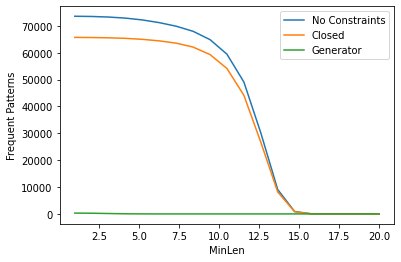

In [ ]:
plt.plot(np.linspace(1,20,19),len_pat,label='No Constraints')
plt.plot(np.linspace(1,20,19),len_pat_clo, label='Closed')
plt.plot(np.linspace(1,20,19),len_pat_gen, label='Generator')
plt.xlabel('MinLen')
#plt.yscale('log')
plt.legend()
plt.ylabel('Frequent Patterns')
plt.savefig('MinLen_walking_up.pdf', bbox_inches = 'tight')


In [ ]:
sup_pat_clo=[]
sup_pat_gen=[]
sup_pat=[]
for i in range(2,20):
  sup_pat_clo.append(len(ps.frequent(i, closed=True,filter=lambda patt, matches: len(patt) > 5)))
  sup_pat.append(len(ps.frequent(i,filter=lambda patt, matches: len(patt) > 5)))
  sup_pat_gen.append(len(ps.frequent(i,generator=True,filter=lambda patt, matches: len(patt) > 5)))


Text(0, 0.5, 'Frequent Patterns')

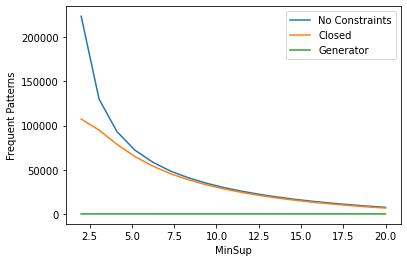

In [ ]:
plt.plot(np.linspace(2,20,20-2),sup_pat,label='No Constraints')
plt.plot(np.linspace(2,20,20-2),sup_pat_clo, label='Closed')
plt.plot(np.linspace(2,20,20-2),sup_pat_gen, label='Generator')
plt.xlabel('MinSup')
#plt.yscale('log')
plt.legend()
plt.ylabel('Frequent Patterns')

#WALKING

I 10 pattern più frequenti sono:

(24, ['4_body_x', '5_body_x', '5_body_x', '4_body_x', '5_body_x', '4_body_x', '5_body_x', '5_body_x', '5_body_x', '5_body_x', '4_body_x'])
(23, ['4_body_x', '5_body_x', '4_body_x', '5_body_x', '4_body_x', '4_body_x', '5_body_x', '4_body_x', '4_body_x', '4_body_x', '4_body_x'])
(23, ['4_body_x', '5_body_x', '4_body_x', '5_body_x', '4_body_x', '5_body_x', '4_body_x', '5_body_x', '4_body_x', '4_body_x', '4_body_x'])
(23, ['4_body_x', '5_body_x', '4_body_x', '5_body_x', '4_body_x', '5_body_x', '4_body_x', '5_body_x', '5_body_x', '4_body_x', '4_body_x'])
(23, ['4_body_x', '5_body_x', '4_body_x', '5_body_x', '4_body_x', '5_body_x', '5_body_x', '5_body_x', '4_body_x', '4_body_x', '4_body_x'])
(23, ['4_body_x', '5_body_x', '5_body_x', '4_body_x', '4_body_x', '4_body_x', '5_body_x', '4_body_x', '4_body_x', '4_body_x', '4_body_x'])
(23, ['5_body_x', '4_body_x', '5_body_x', '4_body_x', '5_body_x', '4_body_x', '5_body_x', '4_body_x', '4_body_x', '4_body_x', '4_bod

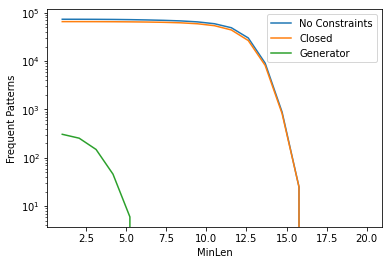

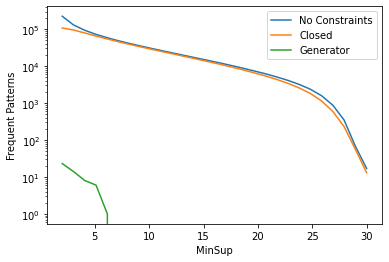

<Figure size 432x288 with 0 Axes>

In [ ]:
np.random.shuffle(X_walking)
ps = PrefixSpan(X_walking)
act='walking'

print('I 10 pattern più frequenti sono:\n')

ao=ps.topk(10,filter=lambda patt, matches: len(patt) > 10)

print(*ao, sep="\n")

len_pat_clo=[]
len_pat_gen=[]
len_pat=[]
for i in range(1,20):
  len_pat.append(len(ps.frequent(5, filter=lambda patt, matches: len(patt) > i)))
  len_pat_clo.append(len(ps.frequent(5, closed=True,filter=lambda patt, matches: len(patt) > i)))
  len_pat_gen.append(len(ps.frequent(5, generator=True,filter=lambda patt, matches: len(patt) > i)))

plt.plot(np.linspace(1,20,19),len_pat,label='No Constraints')
plt.plot(np.linspace(1,20,19),len_pat_clo, label='Closed')
plt.plot(np.linspace(1,20,19),len_pat_gen, label='Generator')
plt.xlabel('MinLen')
plt.yscale('log')
plt.legend()
plt.ylabel('Frequent Patterns')
plt.show()
plt.savefig('MinLen_'+act+'.pdf', bbox_inches = 'tight')


sup_pat_clo=[]
sup_pat_gen=[]
sup_pat=[]
for i in range(2,30):
  sup_pat_clo.append(len(ps.frequent(i, closed=True,filter=lambda patt, matches: len(patt) > 5)))
  sup_pat.append(len(ps.frequent(i,filter=lambda patt, matches: len(patt) > 5)))
  sup_pat_gen.append(len(ps.frequent(i,generator=True,filter=lambda patt, matches: len(patt) > 5)))

plt.plot(np.linspace(2,30,30-2),sup_pat,label='No Constraints')
plt.plot(np.linspace(2,30,30-2),sup_pat_clo, label='Closed')
plt.plot(np.linspace(2,30,30-2),sup_pat_gen, label='Generator')
plt.xlabel('MinSup')
plt.yscale('log')
plt.legend()
plt.ylabel('Frequent Patterns')
plt.show()
plt.savefig('MinSup_'+act+'.pdf', bbox_inches = 'tight')


#WALKING UPSTAIRS

I 10 pattern più frequenti sono:

(25, ['4_body_x', '5_body_x', '4_body_x', '5_body_x', '5_body_x', '4_body_x', '5_body_x', '4_body_x', '5_body_x', '4_body_x', '4_body_x'])
(25, ['4_body_y', '5_body_y', '5_body_y', '5_body_y', '5_body_y', '5_body_y', '5_body_y', '5_body_y', '5_body_y', '5_body_y', '5_body_y'])
(24, ['4_body_x', '5_body_x', '5_body_x', '5_body_x', '5_body_x', '5_body_x', '4_body_x', '5_body_x', '4_body_x', '5_body_x', '5_body_x'])
(24, ['4_body_x', '5_body_x', '5_body_x', '5_body_x', '5_body_x', '5_body_x', '5_body_x', '4_body_x', '5_body_x', '4_body_x', '5_body_x'])
(24, ['4_body_x', '5_body_x', '5_body_x', '5_body_x', '5_body_x', '5_body_x', '5_body_x', '4_body_x', '5_body_x', '5_body_x', '5_body_x'])
(24, ['4_body_y', '5_body_y', '4_body_y', '4_body_y', '5_body_y', '5_body_y', '5_body_y', '4_body_y', '5_body_y', '4_body_y', '5_body_y'])
(24, ['4_body_y', '5_body_y', '4_body_y', '5_body_y', '5_body_y', '5_body_y', '5_body_y', '5_body_y', '5_body_y', '4_body_y', '5_bod

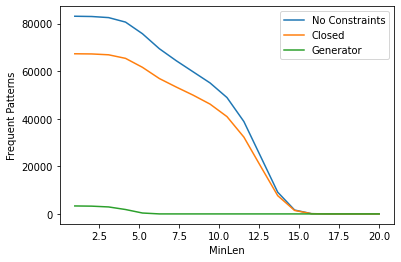

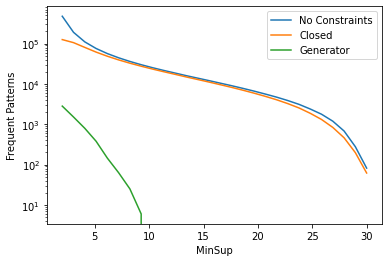

In [ ]:
np.random.shuffle(X_walking_up)

ps = PrefixSpan(X_walking_up)
act='walking_up'

print('I 10 pattern più frequenti sono:\n')

ao=ps.topk(10,filter=lambda patt, matches: len(patt) > 10)

print(*ao, sep="\n")

len_pat_clo=[]
len_pat_gen=[]
len_pat=[]
for i in range(1,20):
  len_pat.append(len(ps.frequent(5, filter=lambda patt, matches: len(patt) > i)))
  len_pat_clo.append(len(ps.frequent(5, closed=True,filter=lambda patt, matches: len(patt) > i)))
  len_pat_gen.append(len(ps.frequent(5, generator=True,filter=lambda patt, matches: len(patt) > i)))

plt.plot(np.linspace(1,20,19),len_pat,label='No Constraints')
plt.plot(np.linspace(1,20,19),len_pat_clo, label='Closed')
plt.plot(np.linspace(1,20,19),len_pat_gen, label='Generator')
plt.xlabel('MinLen')
#plt.yscale('log')
plt.legend()
plt.ylabel('Frequent Patterns')
plt.savefig('MinLen_'+act+'.pdf', bbox_inches = 'tight')
plt.show()


sup_pat_clo=[]
sup_pat_gen=[]
sup_pat=[]
for i in range(2,30):
  sup_pat_clo.append(len(ps.frequent(i, closed=True,filter=lambda patt, matches: len(patt) > 5)))
  sup_pat.append(len(ps.frequent(i,filter=lambda patt, matches: len(patt) > 5)))
  sup_pat_gen.append(len(ps.frequent(i,generator=True,filter=lambda patt, matches: len(patt) > 5)))

plt.plot(np.linspace(2,30,30-2),sup_pat,label='No Constraints')
plt.plot(np.linspace(2,30,30-2),sup_pat_clo, label='Closed')
plt.plot(np.linspace(2,30,30-2),sup_pat_gen, label='Generator')
plt.xlabel('MinSup')
plt.yscale('log')
plt.legend()
plt.ylabel('Frequent Patterns')
plt.savefig('MinSup_'+act+'.pdf', bbox_inches = 'tight')

plt.show()


#WALKING DOWNSTAIRS

In [ ]:
np.random.shuffle(X_walking_down)

ps = PrefixSpan(X_walking_down)
act='walking_down'

print('I 10 pattern più frequenti sono:\n')

ao=ps.topk(10,filter=lambda patt, matches: len(patt) > 10)

print(*ao, sep="\n")

len_pat_clo=[]
len_pat_gen=[]
len_pat=[]
for i in range(1,20):
  len_pat.append(len(ps.frequent(5, filter=lambda patt, matches: len(patt) > i)))
  len_pat_clo.append(len(ps.frequent(5, closed=True,filter=lambda patt, matches: len(patt) > i)))
  len_pat_gen.append(len(ps.frequent(5, generator=True,filter=lambda patt, matches: len(patt) > i)))

plt.plot(np.linspace(1,20,19),len_pat,label='No Constraints')
plt.plot(np.linspace(1,20,19),len_pat_clo, label='Closed')
plt.plot(np.linspace(1,20,19),len_pat_gen, label='Generator')
plt.xlabel('MinLen')
#plt.yscale('log')
plt.legend()
plt.ylabel('Frequent Patterns')
plt.show()
plt.savefig('MinLen_'+act+'.pdf', bbox_inches = 'tight')


sup_pat_clo=[]
sup_pat_gen=[]
sup_pat=[]
for i in range(2,30):
  sup_pat_clo.append(len(ps.frequent(i, closed=True,filter=lambda patt, matches: len(patt) > 5)))
  sup_pat.append(len(ps.frequent(i,filter=lambda patt, matches: len(patt) > 5)))
  sup_pat_gen.append(len(ps.frequent(i,generator=True,filter=lambda patt, matches: len(patt) > 5)))

plt.plot(np.linspace(2,30,30-2),sup_pat,label='No Constraints')
plt.plot(np.linspace(2,30,30-2),sup_pat_clo, label='Closed')
plt.plot(np.linspace(2,30,30-2),sup_pat_gen, label='Generator')
plt.xlabel('MinSup')
plt.yscale('log')
plt.legend()
plt.ylabel('Frequent Patterns')
plt.show()
plt.savefig('MinSup_'+act+'.pdf', bbox_inches = 'tight')


I 10 pattern più frequenti sono:

(25, ['5_body_x', '4_body_x', '5_body_x', '4_body_x', '5_body_x', '4_body_x', '4_body_x', '4_body_x', '5_body_x', '4_body_x', '4_body_x'])
(25, ['5_body_x', '4_body_x', '5_body_x', '5_body_x', '4_body_x', '5_body_x', '4_body_x', '5_body_x', '4_body_x', '4_body_x', '5_body_x'])
(24, ['5_body_x', '4_body_x', '5_body_x', '4_body_x', '5_body_x', '4_body_x', '4_body_x', '5_body_x', '4_body_x', '5_body_x', '4_body_x'])
(24, ['5_body_x', '4_body_x', '5_body_x', '4_body_x', '5_body_x', '4_body_x', '5_body_x', '4_body_x', '5_body_x', '4_body_x', '4_body_x'])
(24, ['5_body_x', '4_body_x', '5_body_x', '4_body_x', '5_body_x', '4_body_x', '5_body_x', '4_body_x', '5_body_x', '4_body_x', '5_body_x'])
(24, ['5_body_x', '5_body_x', '4_body_x', '5_body_x', '4_body_x', '5_body_x', '4_body_x', '5_body_x', '4_body_x', '5_body_x', '4_body_x'])
(24, ['5_body_x', '5_body_x', '4_body_x', '5_body_x', '5_body_x', '4_body_x', '5_body_x', '4_body_x', '5_body_x', '4_body_x', '4_bod

KeyboardInterrupt: ignored

#SITTING

In [ ]:
np.random.shuffle(X_sitting)

ps = PrefixSpan(X_sitting)
act='sitting'

print('I 10 pattern più frequenti sono:\n')

ao=ps.topk(10,filter=lambda patt, matches: len(patt) > 10)

print(*ao, sep="\n")


#len_pat_clo=[]
#len_pat_gen=[]
#len_pat=[]
#for i in range(1,20):
#  len_pat.append(len(ps.frequent(5, filter=lambda patt, matches: len(patt) > i)))
#  len_pat_clo.append(len(ps.frequent(5, closed=True,filter=lambda patt, matches: len(patt) > i)))
#  len_pat_gen.append(len(ps.frequent(5, generator=True,filter=lambda patt, matches: len(patt) > i)))
#
#plt.plot(np.linspace(1,20,19),len_pat,label='No Constraints')
#plt.plot(np.linspace(1,20,19),len_pat_clo, label='Closed')
#plt.plot(np.linspace(1,20,19),len_pat_gen, label='Generator')
#plt.xlabel('MinLen')
##plt.yscale('log')
#plt.legend()
#plt.ylabel('Frequent Patterns')
#plt.show()
#plt.savefig('MinLen_'+act+'.pdf', bbox_inches = 'tight')
#
#
#sup_pat_clo=[]
#sup_pat_gen=[]
#sup_pat=[]
#for i in range(2,30):
#  sup_pat_clo.append(len(ps.frequent(i, closed=True,filter=lambda patt, matches: len(patt) > 5)))
#  sup_pat.append(len(ps.frequent(i,filter=lambda patt, matches: len(patt) > 5)))
#  sup_pat_gen.append(len(ps.frequent(i,generator=True,filter=lambda patt, matches: len(patt) > 5)))
#
#plt.plot(np.linspace(2,30,30-2),sup_pat,label='No Constraints')
#plt.plot(np.linspace(2,30,30-2),sup_pat_clo, label='Closed')
#plt.plot(np.linspace(2,30,30-2),sup_pat_gen, label='Generator')
#plt.xlabel('MinSup')
#plt.yscale('log')
#plt.legend()
#plt.ylabel('Frequent Patterns')
#plt.show()
#plt.savefig('MinSup_'+act+'.pdf', bbox_inches = 'tight')


I 10 pattern più frequenti sono:

(21, ['4_body_y', '4_body_y', '4_body_y', '4_body_y', '4_body_y', '4_body_y', '4_body_y', '4_body_y', '4_body_y', '4_body_y', '4_body_y'])
(19, ['4_body_y', '4_body_y', '4_body_y', '4_body_y', '4_body_y', '4_body_y', '4_body_y', '4_body_y', '4_body_y', '4_body_y', '4_body_y', '4_body_y'])
(18, ['4_body_y', '4_body_y', '4_body_y', '4_body_y', '4_body_y', '4_body_y', '4_body_y', '4_body_y', '4_body_y', '4_body_y', '4_body_y', '4_body_y', '4_body_y'])
(18, ['5_body_x', '5_body_x', '5_body_x', '5_body_x', '5_body_x', '5_body_x', '5_body_x', '5_body_x', '5_body_x', '5_body_x', '5_body_x'])
(13, ['4_body_y', '4_body_y', '4_body_y', '4_body_y', '4_body_y', '4_body_y', '4_body_y', '4_body_y', '4_body_y', '4_body_y', '5_body_y'])
(13, ['4_body_y', '4_body_y', '4_body_y', '4_body_y', '4_body_y', '4_body_y', '4_body_y', '4_body_y', '4_body_y', '5_body_y', '4_body_y'])
(13, ['4_body_y', '4_body_y', '4_body_y', '5_body_y', '4_body_y', '4_body_y', '4_body_y', '4_bod

#STANDING

In [ ]:
np.random.shuffle(X_standing)

ps = PrefixSpan(X_standing)
act='standing'

print('I 10 pattern più frequenti sono:\n')

ao=ps.topk(10,filter=lambda patt, matches: len(patt) > 10)

print(*ao, sep="\n")

#len_pat_clo=[]
#len_pat_gen=[]
#len_pat=[]
#for i in range(1,20):
#  len_pat.append(len(ps.frequent(5, filter=lambda patt, matches: len(patt) > i)))
#  len_pat_clo.append(len(ps.frequent(5, closed=True,filter=lambda patt, matches: len(patt) > i)))
#  len_pat_gen.append(len(ps.frequent(5, generator=True,filter=lambda patt, matches: len(patt) > i)))
#
#plt.plot(np.linspace(1,20,19),len_pat,label='No Constraints')
#plt.plot(np.linspace(1,20,19),len_pat_clo, label='Closed')
#plt.plot(np.linspace(1,20,19),len_pat_gen, label='Generator')
#plt.xlabel('MinLen')
##plt.yscale('log')
#plt.legend()
#plt.ylabel('Frequent Patterns')
#plt.show()
#plt.savefig('MinLen_'+act+'.pdf', bbox_inches = 'tight')
#
#
#sup_pat_clo=[]
#sup_pat_gen=[]
#sup_pat=[]
#for i in range(2,30):
#  sup_pat_clo.append(len(ps.frequent(i, closed=True,filter=lambda patt, matches: len(patt) > 5)))
#  sup_pat.append(len(ps.frequent(i,filter=lambda patt, matches: len(patt) > 5)))
#  sup_pat_gen.append(len(ps.frequent(i,generator=True,filter=lambda patt, matches: len(patt) > 5)))
#
#plt.plot(np.linspace(2,30,30-2),sup_pat,label='No Constraints')
#plt.plot(np.linspace(2,30,30-2),sup_pat_clo, label='Closed')
#plt.plot(np.linspace(2,30,30-2),sup_pat_gen, label='Generator')
#plt.xlabel('MinSup')
#plt.yscale('log')
#plt.legend()
#plt.ylabel('Frequent Patterns')
#plt.show()
#plt.savefig('MinSup_'+act+'.pdf', bbox_inches = 'tight')


I 10 pattern più frequenti sono:

(18, ['4_body_x', '4_body_x', '4_body_x', '4_body_x', '4_body_x', '4_body_x', '4_body_x', '4_body_x', '4_body_x', '4_body_x', '4_body_x'])
(17, ['4_gyro_y', '4_gyro_y', '4_gyro_y', '4_gyro_y', '4_gyro_y', '4_gyro_y', '4_gyro_y', '4_gyro_y', '4_gyro_y', '4_gyro_y', '4_gyro_y'])
(16, ['4_body_x', '4_body_x', '4_body_x', '4_body_x', '4_body_x', '4_body_x', '4_body_x', '4_body_x', '4_body_x', '4_body_x', '4_body_x', '4_body_x'])
(16, ['4_gyro_y', '4_gyro_y', '4_gyro_y', '4_gyro_y', '4_gyro_y', '4_gyro_y', '4_gyro_y', '4_gyro_y', '4_gyro_y', '4_gyro_y', '4_gyro_y', '4_gyro_y'])
(14, ['4_gyro_y', '5_gyro_y', '4_gyro_y', '4_gyro_y', '4_gyro_y', '4_gyro_y', '4_gyro_y', '4_gyro_y', '4_gyro_y', '4_gyro_y', '4_gyro_y'])
(13, ['4_body_x', '4_body_x', '4_body_x', '4_body_x', '4_body_x', '4_body_x', '4_body_x', '4_body_x', '4_body_x', '4_body_x', '4_body_x', '4_body_x', '4_body_x'])
(13, ['4_gyro_x', '4_gyro_x', '4_gyro_x', '4_gyro_x', '4_gyro_x', '4_gyro_x', '4_gyr

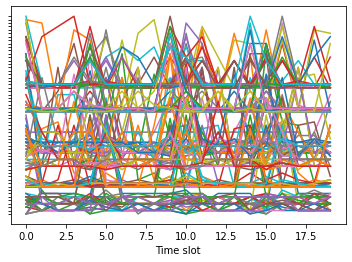

I 10 pattern più frequenti sono:

(18, ['5_body_x', '5_body_x', '5_body_x', '5_body_x', '5_body_x', '5_body_x', '5_body_x', '5_body_x', '5_body_x', '5_body_x', '5_body_x'])
(14, ['4_body_z', '4_body_z', '4_body_z', '4_body_z', '4_body_z', '4_body_z', '4_body_z', '4_body_z', '4_body_z', '4_body_z', '4_body_z'])
(14, ['5_body_y', '5_body_y', '5_body_y', '5_body_y', '5_body_y', '5_body_y', '5_body_y', '5_body_y', '5_body_y', '5_body_y', '5_body_y'])
(14, ['5_body_y', '5_body_y', '5_body_y', '5_body_y', '5_body_y', '5_body_y', '5_body_y', '5_body_y', '5_body_y', '5_body_y', '5_body_y', '5_body_y'])
(14, ['5_gyro_y', '5_gyro_y', '5_gyro_y', '5_gyro_y', '5_gyro_y', '5_gyro_y', '5_gyro_y', '5_gyro_y', '5_gyro_y', '5_gyro_y', '5_gyro_y'])
(13, ['5_body_x', '5_body_x', '5_body_x', '5_body_x', '5_body_x', '5_body_x', '5_body_x', '5_body_x', '4_body_x', '5_body_x', '5_body_x'])
(13, ['5_body_y', '5_body_y', '5_body_y', '5_body_y', '5_body_y', '5_body_y', '5_body_y', '5_body_y', '5_body_y', '5_bod

In [ ]:
np.random.shuffle(X_laying)

ps = PrefixSpan(X_laying)

for i in range(0,180):
  plt.plot(X_laying[i])
plt.xlabel('Time slot')
#plt.ylabel('TS')
frame1 = plt.gca()
#frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
plt.savefig('X_laying_TS.pdf', bbox_inches = 'tight')
plt.show()

print('I 10 pattern più frequenti sono:\n')

ao=ps.topk(10,filter=lambda patt, matches: len(patt) > 10)

print(*ao, sep="\n")

#len_pat_clo=[]
#len_pat_gen=[]
#len_pat=[]
#for i in range(1,20):
#  len_pat.append(len(ps.frequent(5, filter=lambda patt, matches: len(patt) > i)))
#  len_pat_clo.append(len(ps.frequent(5, closed=True,filter=lambda patt, matches: len(patt) > i)))
#  len_pat_gen.append(len(ps.frequent(5, generator=True,filter=lambda patt, matches: len(patt) > i)))
#
#plt.plot(np.linspace(1,20,19),len_pat,label='No Constraints')
#plt.plot(np.linspace(1,20,19),len_pat_clo, label='Closed')
#plt.plot(np.linspace(1,20,19),len_pat_gen, label='Generator')
#plt.xlabel('MinLen')
##plt.yscale('log')
#plt.legend()
#plt.ylabel('Frequent Patterns')
#plt.show()
#plt.savefig('MinLen_laying.pdf', bbox_inches = 'tight')
#
#
#sup_pat_clo=[]
#sup_pat_gen=[]
#sup_pat=[]
#for i in range(2,30):
#  sup_pat_clo.append(len(ps.frequent(i, closed=True,filter=lambda patt, matches: len(patt) > 5)))
#  sup_pat.append(len(ps.frequent(i,filter=lambda patt, matches: len(patt) > 5)))
#  sup_pat_gen.append(len(ps.frequent(i,generator=True,filter=lambda patt, matches: len(patt) > 5)))
#
#plt.plot(np.linspace(2,30,30-2),sup_pat,label='No Constraints')
#plt.plot(np.linspace(2,30,30-2),sup_pat_clo, label='Closed')
#plt.plot(np.linspace(2,30,30-2),sup_pat_gen, label='Generator')
#plt.xlabel('MinSup')
#plt.yscale('log')
#plt.legend()
#plt.ylabel('Frequent Patterns')
#plt.show()
#plt.savefig('MinSup_laying.pdf', bbox_inches = 'tight')


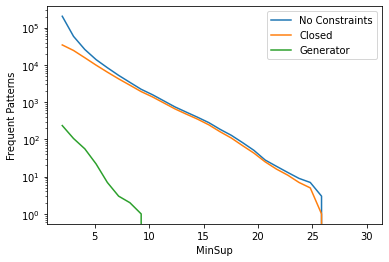

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(np.linspace(2,30,30-2),sup_pat,label='No Constraints')
plt.plot(np.linspace(2,30,30-2),sup_pat_clo, label='Closed')
plt.plot(np.linspace(2,30,30-2),sup_pat_gen, label='Generator')
plt.xlabel('MinSup')
plt.yscale('log')
plt.legend()
plt.ylabel('Frequent Patterns')
plt.show()
plt.savefig('MinSup_walking_up.pdf', bbox_inches = 'tight')

#Istogrammi

     Activity  body_x  body_y  body_z  gyro_x  gyro_y  gyro_z
0     Walking     185       0      46       0       0       0
1    Upstairs     217       0      25       0       0       0
2  Downstairs     218       0      24       0       0       0
3     Sitting      31      97       0       0      12      13
4    Standing      59      13       0      13      60       0
5      Laying      31      41      38       0      25       0


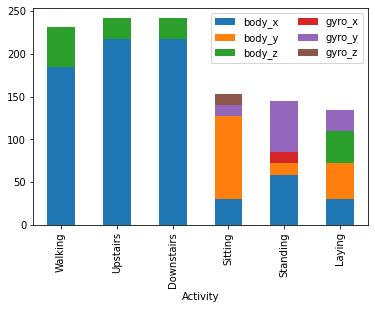

In [ ]:

fig, ax = plt.subplots(figsize =(6, 4))

df = pd.DataFrame([['Walking', 185, 0, 46, 0,0,0], 
                   ['Upstairs', 217, 0, 25, 0,0,0], 
                   ['Downstairs', 218, 0, 24, 0,0,0],
                   ['Sitting', 31,97,0,0,12,13],
                   ['Standing',18+16+13+12,13,0,13,17+16+14+13,0],
                   ['Laying',18+13,14*2+13,14+12*2,0,14+11,0]],
                  columns=['Activity', 'body_x', 'body_y', 'body_z', 'gyro_x','gyro_y','gyro_z'])
# view data
print(df)
  
# plot data in stack manner of bar type
df.plot(x='Activity', kind='bar', stacked=True,ax=ax)

ax.legend(ncol=2);
ax.figure.savefig('histo.pdf', bbox_inches = 'tight')
